### Part 1: Building the Core Architecture

This notebook covers the main part of the project: implementing the custom Swin Transformer model. The first step is to define all the custom layers needed, like PatchEmbedding, WindowAttention, and the main SwinTransformer block itself. This is the foundation of the model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import os

# --- Model Hyperparameters ---
num_classes = 5
input_shape = (224, 224, 3)
patch_size = (4, 4)
num_heads = 6
embed_dim = 96
num_mlp = 384
qkv_bias = True
window_size = 7
shift_size = 3
image_dimension = 224

# --- Calculate patch details ---
num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]
print(f"Number of patches: {num_patch_x}x{num_patch_y} = {num_patch_x * num_patch_y}")

Number of patches: 56x56 = 3136


### Helper Functions

These two functions are used to partition the image into windows and then reverse the proccess. This is a core idea of the Swin Transformer to compute attention locally.

In [2]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x, (-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows

def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows, (-1, patch_num_y, patch_num_x, window_size, window_size, channels)
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

### Core Layers Implementation

Now, I'm defining the main custom layers for the model.

1.  **WindowAttention**: Computes self-attention within local windows.
2.  **SwinTransformer**: The main block that combines window attention with the MLP.
3.  **PatchEmbedding**: Converts image patches to vector embeddings.
4.  **PatchMerging**: Downsamples the image by merging patches, which creates the hirearchical structure.

In [18]:
@keras.saving.register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        # Define relative position bias
        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(self.relative_position_bias_table, relative_position_index_flat, axis=0)
        relative_position_bias = ops.reshape(relative_position_bias, (num_window_elements, num_window_elements, -1))
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0), "float32")
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)

        attn = self.dropout(attn)
        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
@keras.saving.register_keras_serializable()
class SwinTransformer(layers.Layer):
    def __init__(self, dim, num_patch, num_heads, window_size=7, shift_size=0, num_mlp=1024, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_patch = num_patch
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)
        self.mlp = keras.Sequential([
            layers.Dense(num_mlp),
            layers.Activation(keras.activations.gelu),
            layers.Dropout(dropout_rate),
            layers.Dense(dim),
            layers.Dropout(dropout_rate),
        ])
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size > 0:
            height, width = self.num_patch
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(mask_windows, axis=2)
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(initializer=attn_mask, shape=attn_mask.shape, dtype=attn_mask.dtype, trainable=False)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(x_windows, (-1, self.window_size * self.window_size, channels))
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = ops.reshape(attn_windows, (-1, self.window_size, self.window_size, channels))
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)
        if self.shift_size > 0:
            x = ops.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x
@keras.saving.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)
@keras.saving.register_keras_serializable()
class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

### Model Assembly

Now I will assemble the layers together to build the final model. For this first attempt, I'll use a simple structure with two SwinTransformer blocks followed by a patch merging layer and a final classification head.

In [4]:
# --- Model Assembly ---
patch_feature_dim = patch_size[0] * patch_size[1] * input_shape[2]
num_patches_total = num_patch_x * num_patch_y
input_layer_shape = (num_patches_total, patch_feature_dim)

input_tensor = layers.Input(shape=input_layer_shape)

# Stage 1
x = PatchEmbedding(num_patches_total, embed_dim)(input_tensor)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    name="swin_stage1_block1"
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    name="swin_stage1_block2"
)(x)

# Downsampling
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)

# Final Classification Head
x = layers.LayerNormalization(epsilon=1e-5)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

# Create the final model
model = keras.Model(input_tensor, output)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3136, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, 3136, 96)       │       305,760 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_stage1_block1              │ (None, 3136, 96)       │       115,255 │
│ (SwinTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_stage1_block2              │ (None, 3136, 96)       │       268,919 │
│ (SwinTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging (PatchMerging)    │ (None, 784, 192)       │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 784, 192)       │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765,011 (3.52 MB)

 Trainable params: 606,545 (2.31 MB)

 Non-trainable params: 158,466 (1.21 MB)

### Part 2: Data Loading and Initial Training Attempt

With the model architecture defined, the next step is to load the pre-processed data and create the `tf.data` pipeline. This involves loading the NumPy arrays we saved earlier and setting up the data pipeline for training.

After that, I will compile the model and run the first training experiment to get a baseline performance.

In [5]:
# --- Training Hyperparameters ---
learning_rate = 1e-3
batch_size = 64
num_epochs = 150
weight_decay = 0.0001
label_smoothing = 0.1

# --- Load Pre-processed Data ---
# Note: This assumes Google Drive is mounted.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_LOAD_DIR = "/content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented"
    x_train = np.load(os.path.join(DRIVE_LOAD_DIR, 'X_train.npy'))
    y_train = np.load(os.path.join(DRIVE_LOAD_DIR, 'y_train_one_hot.npy'))
    # For now, I will create a validation set from the training data for a quick check
    print(f"Loaded x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
except Exception as e:
    print(f"Error loading data. Make sure you've run the preprocessing notebook. Details: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded x_train shape: (8790, 224, 224, 3) - y_train shape: (8790, 5)


### Create `tf.data` Pipeline

I'm creating the data pipeline. One important step here is extracting patches from the images, because the Swin Transformer doesn't work on whole images directly. The `patch_extract_wrapper` function handles this.

In [6]:
# This function extracts patches from images, a required step for the model
def patch_extract_wrapper(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

# Creating a validation split from the training data for this run
val_split_index = int(len(x_train) * 0.9)
x_val_split = x_train[val_split_index:]
y_val_split = y_train[val_split_index:]
x_train_split = x_train[:val_split_index]
y_train_split = y_train[:val_split_index]


# Create the training dataset pipeline
dataset = (
    tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# Create the validation dataset pipeline
dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Training and validation tf.data pipelines created.")

Training and validation tf.data pipelines created.


### Compile and Train the Model

Now, everything is ready. I'll compile the model with the AdamW optimizer and categorical cross-entropy loss. Then, I will start the first training run.

### Update: Resolving a Memory Error

After running the initial setup, the training failed due to a `ResourceExhaustedError`. Even with Google Colab Pro, the `batch_size` of 128 proved to be too demanding for the GPU. To fix this, I'm reducing the batch size to a more reasonable value of 64. I will now restart the training.

In [ ]:
# Compile the model
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Start training
print("\nStarting the first training experiment...")
history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)


Starting the first training experiment...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - accuracy: 0.4329 - loss: 1.7579 - top-2-accuracy: 0.6631 - val_accuracy: 0.6166 - val_loss: 1.1538 - val_top-2-accuracy: 0.8111
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - accuracy: 0.6042 - loss: 1.1989 - top-2-accuracy: 0.7835 - val_accuracy: 0.6735 - val_loss: 1.0831 - val_top-2-accuracy: 0.8237
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.6475 - loss: 1.1144 - top-2-accuracy: 0.8117 - val_accuracy: 0.6826 - val_loss: 1.0590 - val_top-2-accuracy: 0.8339
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.6648 - loss: 1.0828 - top-2-accuracy: 0.8228 - val_accuracy: 0.6917 - val_loss: 1.0499 - val_top-2-accuracy: 0.8407
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.6731 - loss: 1.0599 - top-2-accuracy: 0.8278 - val_accuracy: 0.6837 - val_loss: 1.0473 - val_top-2-accuracy: 0.8464
Epoch 6/150
124/124 ━━━━━━━

### Part 3: Analyzing the First Training Results

The training has now completed, and the results are not ideal. As can be seen from the logs above, the training accuracy climbed to over 97%, but the validation accuracy stalled around 68% and then started to fluctuate or even decrease. Similarly, the validation loss began to increase after an initial drop.

This is a clear indication of **severe overfiting**. The model has memorized the training set but failed to generalize to new data. For the next attempt, I need to implement a mechanism to stop the training process before this overfitting becomes too extreme.

### Part 4: Visualizing Performance and Adding Evaluation Metrics

To get a clearer picture of the overfitting problem, I'll now visualize the training history. I'm also adding more detailed evaluation functions to generate classification reports and confusion matrices for future experiments.

Plotting the training history from the first experiment...


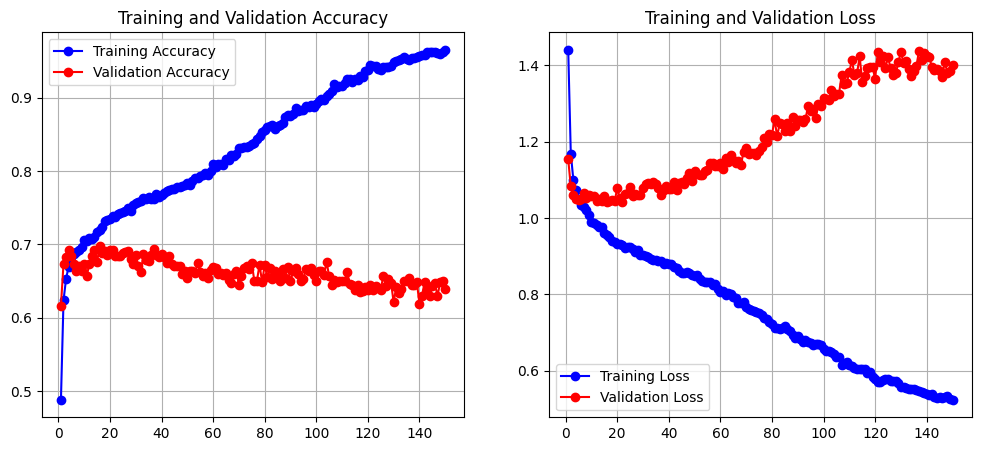

Evaluation functions defined.


In [23]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    # Function to plot the training and validation curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the curves from the completed training run
print("Plotting the training history from the first experiment...")
plot_training_history(history)



def evaluate_model(model, dataset):
    print("\nGenerating predictions for evaluation...")
    y_pred_probs = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true_classes = []
    for _, labels in dataset:
        y_true_classes.extend(np.argmax(labels.numpy(), axis=1))

    y_true_classes = np.array(y_true_classes)

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    # Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Evaluation functions defined.")

### Part 5: Second Training Attempt with Callbacks

Based on the analysis of the first run, the key issue was training for too long. To combat this, I will now introduce Keras Callbacks into the training process.

1.  **`EarlyStopping`**: This will monitor the `val_loss` and stop the training automatically when it stops improving, preventing the model from overfitting.
2.  **`ModelCheckpoint`**: This will save only the best version of the model (the one with the lowest `val_loss`) during the entire training process.

This is a much more robust approach to training.

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    patience=10,              # Stop training if val_loss doesn't improve for 10 consecutive epochs
    verbose=1,                # Print messages when stopping
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Define the path to save the best model
best_model_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras"

model_checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True, # Only save the model if `val_loss` has improved
    verbose=1
)

print("Callbacks for Early Stopping and Model Checkpointing have been defined.")

Callbacks for Early Stopping and Model Checkpointing have been defined.


### Re-compiling and Re-training

I will re-compile the model to reset its weights and then start the training process again, this time using the callbacks. I'm still setting `epochs` to a high number, but I expect the `EarlyStopping` callback to finish the training much earlier.

In [8]:
# Re-compile the model to reset the optimizer and weights
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Start the second, improved training run
print("\nStarting the second training experiment with callbacks...")
history_improved = model.fit(
    dataset,
    epochs=150, # Set a high number, but expect it to stop early
    validation_data=dataset_val,
    callbacks=[early_stopping_callback, model_checkpoint_callback] # Pass the callbacks here
)

print("\n--- Improved Training Finished ---")


Starting the second training experiment with callbacks...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4351 - loss: 1.6132 - top-2-accuracy: 0.6638
Epoch 1: val_loss improved from inf to 1.14290, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 74s 423ms/step - accuracy: 0.4357 - loss: 1.6113 - top-2-accuracy: 0.6644 - val_accuracy: 0.6394 - val_loss: 1.1429 - val_top-2-accuracy: 0.8168
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6256 - loss: 1.1736 - top-2-accuracy: 0.7892
Epoch 2: val_loss improved from 1.14290 to 1.09047, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.6257 - loss: 1.1734 - top-2-accuracy: 0.7892 - val_accuracy: 0.6746 - val_loss: 1.0905 - val_top-2-accuracy: 0.8203
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6565 - loss: 1.1087 - top-2-

### Analyzing the Improved Training Run

Now let's plot the history from this second run. I expect to see that the training stopped before the validation loss started to increase significantly.

In [11]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    # Function to plot the training and validation curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()




def evaluate_model(model, dataset):
    print("\nGenerating predictions for evaluation...")
    y_pred_probs = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true_classes = []
    for _, labels in dataset:
        y_true_classes.extend(np.argmax(labels.numpy(), axis=1))

    y_true_classes = np.array(y_true_classes)

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    # Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Evaluation functions defined.")

Evaluation functions defined.


Plotting the training history from the second, improved experiment...


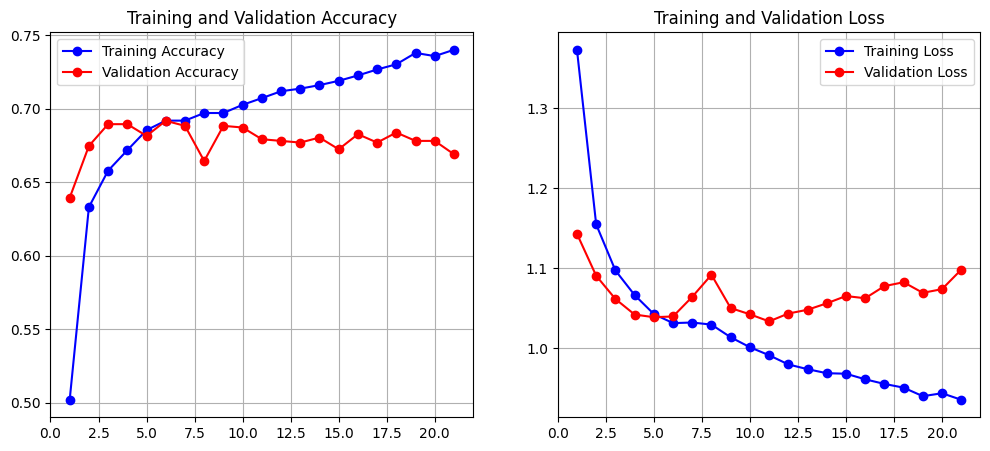


Loading the best model saved at: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_merging', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



--- Final Evaluation on Validation Set (using best model) ---

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step

--- Classification Report ---
               precision    recall  f1-score   support

        No DR       0.82      0.92      0.87       465
         Mild       0.24      0.35      0.28        63
     Moderate       0.55      0.60      0.57       240
       Severe       1.00      0.02      0.05        42
Proliferative       0.00      0.00      0.00        69

     accuracy                           0.68       879
    macro avg       0.52      0.38      0.35       879
 weighted avg       0.65      0.68      0.64       879


--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


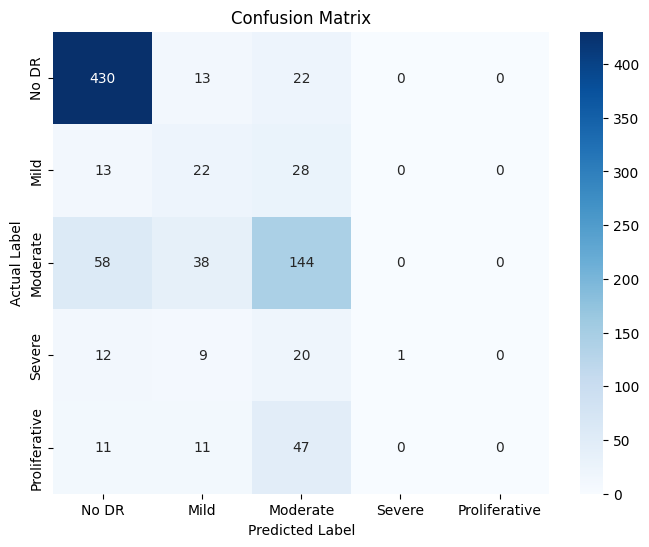

In [12]:
# Plot the results of the second training run
print("Plotting the training history from the second, improved experiment...")
plot_training_history(history_improved)

# Load the best model that was saved by ModelCheckpoint
print(f"\nLoading the best model saved at: {best_model_path}")
best_model = keras.models.load_model(best_model_path)

# Finally, evaluate the *best* model on the validation set
print("\n--- Final Evaluation on Validation Set (using best model) ---")
evaluate_model(best_model, dataset_val)

### Part 6: Final Analysis of the Improved Model

The second training run, which used `EarlyStopping`, has now completed. The process stopped automatically, preventing the severe overfitting seen in the first attempt.

Now, I will load the best version of the model that was saved by `ModelCheckpoint`. However, loading a model with custom layers requires a special step. I encountered a `TypeError` because Keras doesn't natively know about my `PatchEmbedding` or `SwinTransformer` layers.

To solve this, I will pass a `custom_objects` dictionary to the `load_model` function. This dictionary explicitly tells Keras which class to use for each custom layer name, ensuring the model can be correctly reconstructed. After loading, I will perform a final, detailed evaluation on the validation set.

Plotting the training history from the second experiment...


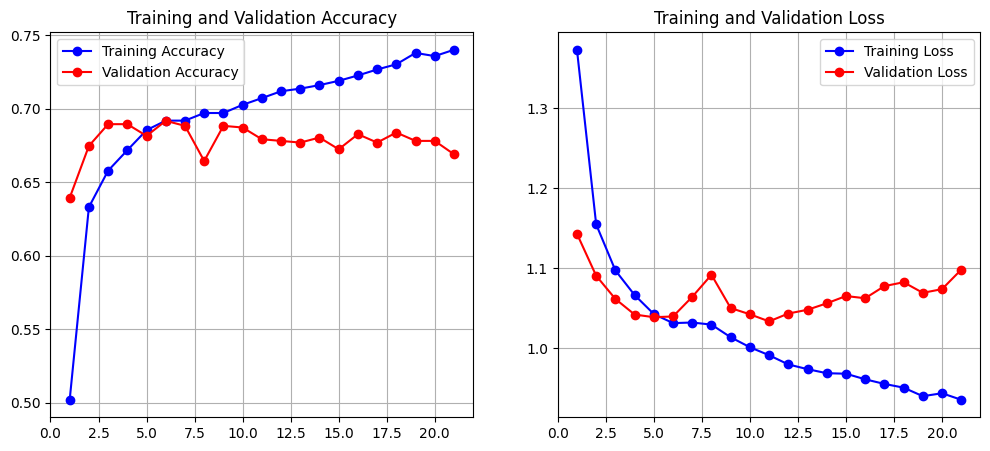


Loading the best model from: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_merging', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Best model loaded successfully!

Preparing validation data for final evaluation...

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step

--- Classification Report (Validation Set) ---
               precision    recall  f1-score   support

        No DR       0.82      0.92      0.87       465
         Mild       0.24      0.35      0.28        63
     Moderate       0.55      0.60      0.57       240
       Severe       1.00      0.02      0.05        42
Proliferative       0.00      0.00      0.00        69

     accuracy                           0.68       879
    macro avg       0.52      0.38      0.35       879
 weighted avg       0.65      0.68      0.64       879


--- Confusion Matrix (Validation Set) ---


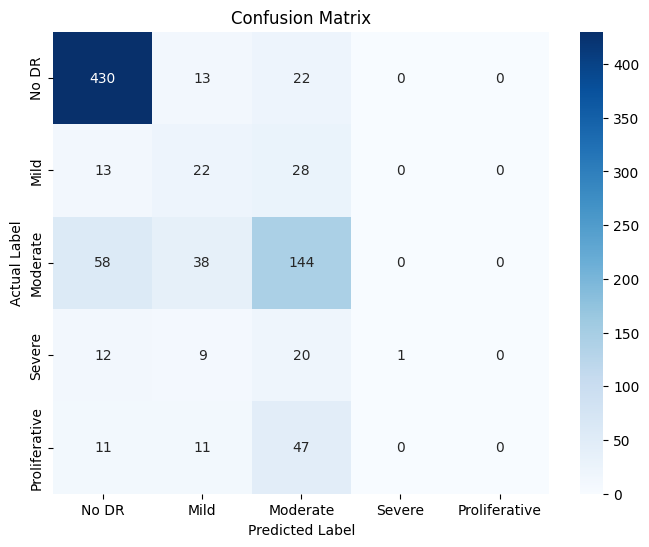

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Helper Functions for Evaluation ---

def plot_training_history(history):
    # This function plots the training and validation curves.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, dataset):
    # This function generates a classification report and confusion matrix.
    print("\nGenerating predictions for evaluation...")
    y_pred_probs = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true_classes = []
    for _, labels in dataset:
        y_true_classes.extend(np.argmax(labels.numpy(), axis=1))

    y_true_classes = np.array(y_true_classes)

    # Ensure lengths match, which can be an issue with batching
    min_len = min(len(y_true_classes), len(y_pred_classes))
    y_true_classes = y_true_classes[:min_len]
    y_pred_classes = y_pred_classes[:min_len]

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    # Classification Report
    print("\n--- Classification Report (Validation Set) ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))

    # Confusion Matrix
    print("\n--- Confusion Matrix (Validation Set) ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- Main Execution for Analysis ---

# 1. Plot the history from the successful training run
print("Plotting the training history from the second experiment...")
plot_training_history(history_improved)

# 2. Define custom objects and load the best model
custom_objects = {
    "WindowAttention": WindowAttention,
    "SwinTransformer": SwinTransformer,
    "PatchEmbedding": PatchEmbedding,
    "PatchMerging": PatchMerging,
}
best_model_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras"
print(f"\nLoading the best model from: {best_model_path}")
best_model = keras.models.load_model(best_model_path, custom_objects=custom_objects)
print("Best model loaded successfully!")


# 3. Create a fresh dataset for evaluation and evaluate the model
print("\nPreparing validation data for final evaluation...")
dataset_val_eval = (
    tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
    .batch(batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

evaluate_model(best_model, dataset_val_eval)

### Final Attempt: A Complete Architectural Refactor

After conducting a series of experiments—from applying `class_weights` to advanced sampling techniques like Oversampling and Undersampling—it has become evident that the initial model implementation has inherent limitations. While overfitting was managed, the model consistently failed to learn the features of the minority classes effectively. The performance has reached a plateau that cannot be surpassed by data manipulation alone.

This leads to the conclusion that the architecture itself needs to be improved. My final hypothesis is that a more robust and professionally structured implementation might overcome these challenges.

For this last experiment, I will completely refactor the model code based on established best practices. The key improvements will be:

1.  **Convolutional Patch Embedding:** Using a `Conv2D` layer for patch embedding, which is more standard and efficient.
2.  **DropPath (Stochastic Depth):** Introducing a powerful regularization layer specifically designed for Transformer-like architectures to further combat overfitting.
3.  **Refactored Code Structure:** Organizing the entire implementation into clean, modular functions (`build_swin_transformer`, `create_model`) and helper utilities for data preparation and evaluation.
4.  **Advanced Learning Rate Scheduling:** Incorporating the `ReduceLROnPlateau` callback to dynamically adjust the learning rate during training for more stable convergence.

This represents a final, all-in effort to build a high-performing model by fundamentally improving its design rather than just tweaking the data.

In [6]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


class DropPath(layers.Layer):
    """Stochastic Depth (DropPath)."""
    def __init__(self, drop_prob=0., **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if (not training) or (self.drop_prob == 0.):
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return tf.divide(x, keep_prob) * binary_tensor

# Patch Embedding (Conv)

class PatchEmbed(layers.Layer):
    def __init__(self, patch_size=4, embed_dim=96, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.proj = layers.Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        # x: (B, H, W, C)
        x = self.proj(x)                  # (B, H/ps, W/ps, embed_dim)
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]
        x = tf.reshape(x, (B, H * W, C))  # (B, N, C)
        x = self.norm(x)
        return x


# MLP used inside blocks
def MLP(hidden_dim, out_dim, drop=0.0):
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.Activation('gelu'),
        layers.Dropout(drop),
        layers.Dense(out_dim),
        layers.Dropout(drop),
    ])

# Window partition / reverse helpers (use TF ops)
def window_partition(x, window_size):
    # x: (B, H, W, C)
    Wh, Ww = window_size
    B = tf.shape(x)[0]
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]
    C = tf.shape(x)[3]
    x = tf.reshape(x, (B, H // Wh, Wh, W // Ww, Ww, C))
    x = tf.transpose(x, perm=(0,1,3,2,4,5))  # B, H//Wh, W//Ww, Wh, Ww, C
    windows = tf.reshape(x, (-1, Wh * Ww, C))
    return windows

def window_reverse(windows, window_size, H, W):
    # windows: (num_windows*B, Wh*Ww, C)
    Wh, Ww = window_size
    num_windows_per_image = (H // Wh) * (W // Ww)
    B = tf.shape(windows)[0] // num_windows_per_image
    x = tf.reshape(windows, (B, H // Wh, W // Ww, Wh, Ww, -1))
    x = tf.transpose(x, perm=(0,1,3,2,4,5))
    x = tf.reshape(x, (B, H, W, -1))
    return x


# Window Attention Layer

class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size=(7,7), num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0., **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)

        # relative position bias table (trainable)
        Wh, Ww = window_size
        num_rel = (2*Wh - 1) * (2*Ww - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_rel, num_heads), initializer='zeros', trainable=True, name='rel_pos_bias'
        )

        # compute relative position index (constant)
        coords_h = np.arange(Wh)
        coords_w = np.arange(Ww)
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))  # 2, Wh, Ww
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose(1, 2, 0)  # N, N, 2
        relative_coords[:, :, 0] += Wh - 1
        relative_coords[:, :, 1] += Ww - 1
        relative_coords[:, :, 0] *= 2 * Ww - 1
        relative_position_index = relative_coords.sum(-1)  # N, N
        self.relative_position_index = tf.convert_to_tensor(relative_position_index, dtype=tf.int32)

    def call(self, x, mask=None):
        B_, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        qkv = self.qkv(x)  # (B_, N, 3*C)
        qkv = tf.reshape(qkv, (B_, N, 3, self.num_heads, self.head_dim))
        qkv = tf.transpose(qkv, perm=(2, 0, 3, 1, 4))  # 3, B_, heads, N, head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: (B_, heads, N, head_dim)

        q = q * self.scale
        attn = tf.matmul(q, k, transpose_b=True)  # (B_, heads, N, N)

        # add relative position bias
        WhWw = self.window_size[0] * self.window_size[1]
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1]))
        relative_position_bias = tf.reshape(relative_position_bias, (WhWw, WhWw, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2,0,1))  # heads, N, N
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = tf.shape(mask)[0]
            # reshape attn to (B_ // nW, nW, heads, N, N)
            attn = tf.reshape(attn, (-1, nW, self.num_heads, N, N))
            attn = attn + tf.expand_dims(tf.expand_dims(mask, 1), 0)
            attn = tf.reshape(attn, (-1, self.num_heads, N, N))

        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        x = tf.matmul(attn, v)  # (B_, heads, N, head_dim)
        x = tf.transpose(x, perm=(0,2,1,3))
        x = tf.reshape(x, (B_, N, C))
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


# Swin Block

class SwinBlock(layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0., **kwargs):
        """
        input_resolution: tuple of ints (H, W) - must be known integers when creating layer
        """
        super().__init__(**kwargs)
        assert isinstance(input_resolution[0], (int, np.integer)) and isinstance(input_resolution[1], (int, np.integer)), \
            "input_resolution must be integers"
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size if shift_size < window_size else 0
        self.mlp_ratio = mlp_ratio

        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn = WindowAttention(dim=dim, window_size=(window_size, window_size),
                                    num_heads=num_heads, qkv_bias=qkv_bias,
                                    attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else layers.Activation('linear')
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(int(dim * mlp_ratio), dim, drop=drop)

        # prepare attention mask for shifted windows if needed (use numpy since H,W int)
        H, W = self.input_resolution
        if self.shift_size > 0:
            img_mask = np.zeros((1, H, W, 1), dtype=np.int32)
            cnt = 0
            h_slices = (slice(0, -window_size), slice(-window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -window_size), slice(-window_size, -self.shift_size), slice(-self.shift_size, None))
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            # partition and compute mask difference
            # convert to TF tensor and use helper partitioning (works with constant shapes)
            mask_windows = window_partition(tf.convert_to_tensor(img_mask, dtype=tf.float32), (window_size, window_size))
            mask_windows = tf.reshape(mask_windows, (-1, window_size * window_size))
            attn_mask = tf.expand_dims(mask_windows, 1) - tf.expand_dims(mask_windows, 2)
            attn_mask = tf.where(attn_mask != 0, tf.constant(-100.0), tf.constant(0.0))
            # keep as a TF variable (non-trainable)
            self.attn_mask = tf.Variable(attn_mask, trainable=False, dtype=tf.float32)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        H, W = self.input_resolution
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, (B, H, W, C))

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, (self.window_size, self.window_size))  # (num_windows*B, Wh*Ww, C)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # (num_windows*B, Wh*Ww, C)

        # merge windows
        shifted_x = window_reverse(attn_windows, (self.window_size, self.window_size), H, W)
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, (B, N, C))

        # FFN and residuals with DropPath
        x = shortcut + self.drop_path(x, training=training)
        x = x + self.drop_path(self.mlp(self.norm2(x)), training=training)
        return x


# Patch Merging (downsample)

class PatchMerging(layers.Layer):
    def __init__(self, input_resolution, dim, **kwargs):
        super().__init__(**kwargs)
        assert isinstance(input_resolution[0], (int, np.integer)) and isinstance(input_resolution[1], (int, np.integer)), \
            "input_resolution must be integers"
        self.input_resolution = input_resolution
        self.dim = dim
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.reduction = layers.Dense(2 * dim, use_bias=False)

    def call(self, x):
        # x: (B, H*W, C)
        H, W = self.input_resolution
        B = tf.shape(x)[0]
        C = tf.shape(x)[2]
        x = tf.reshape(x, (B, H, W, C))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat([x0, x1, x2, x3], axis=-1)  # B H/2 W/2 4*C
        x = tf.reshape(x, (B, -1, 4 * C))
        x = self.norm(x)
        x = self.reduction(x)  # B, H/2*W/2, 2*C
        return x


# Build Swin Transformer backbone
def build_swin_transformer(
    input_shape=(224,224,3),
    patch_size=4,
    num_classes=5,
    embed_dim=96,
    depths=(2,2,6,2),
    num_heads=(3,6,12,24),
    window_size=7,
    mlp_ratio=4.,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    small=False
):
    # Validate depths/num_heads lengths
    assert len(depths) == len(num_heads), "depths and num_heads must have same length"

    # compute initial patch resolution (integers)
    H_img, W_img = input_shape[0], input_shape[1]
    assert H_img % patch_size == 0 and W_img % patch_size == 0, "Image size must be divisible by patch_size"
    H = H_img // patch_size
    W = W_img // patch_size

    img_input = layers.Input(shape=input_shape)

    # patch embedding
    x = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)(img_input)  # (B, H*W, embed_dim)

    total_blocks = sum(depths)
    dpr = list(np.linspace(0.0, drop_path_rate, total_blocks))

    cur_resolution = (H, W)
    cur_dim = embed_dim
    block_idx = 0
    cur = x

    for stage_idx, (stage_depth, n_head) in enumerate(zip(depths, num_heads)):
        for i in range(stage_depth):
            shift = 0 if (i % 2 == 0) else window_size // 2
            cur = SwinBlock(dim=cur_dim, input_resolution=cur_resolution, num_heads=n_head,
                            window_size=window_size, shift_size=shift, mlp_ratio=mlp_ratio,
                            qkv_bias=True, drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dpr[block_idx])(cur)
            block_idx += 1

        # patch merging except last stage
        if stage_idx < len(depths) - 1:
            cur = PatchMerging(input_resolution=cur_resolution, dim=cur_dim)(cur)
            cur_resolution = (cur_resolution[0] // 2, cur_resolution[1] // 2)
            cur_dim = cur_dim * 2

    # final head
    x = layers.LayerNormalization(epsilon=1e-6)(cur)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(img_input, out)
    return model


In [7]:
# Helper: create lighter config if GPU limited
def create_model(input_shape=(224,224,3), num_classes=5, small=True):
    if small:
        return build_swin_transformer(input_shape=input_shape, patch_size=4, num_classes=num_classes,
                                      embed_dim=64, depths=(2,2,2,2), num_heads=(2,4,8,16),
                                      window_size=7, drop_rate=0.1, drop_path_rate=0.1)
    else:
        return build_swin_transformer(input_shape=input_shape, patch_size=4, num_classes=num_classes,
                                      embed_dim=96, depths=(2,2,6,2), num_heads=(3,6,12,24),
                                      window_size=7, drop_rate=0.1, drop_path_rate=0.2)

In [8]:

# === Training / Data pipeline utilities ===

def prepare_datasets_from_numpy(x, y, val_split=0.1, batch_size=32, augment=False, buffer_size=2048):
    # x: numpy images (N, H, W, 3) ; y: one-hot or integer labels
    N = len(x)
    idx = int(N * (1 - val_split))
    x_train, y_train = x[:idx], y[:idx]
    x_val, y_val = x[idx:], y[idx:]

    def _prep(image, label):
        # convert and normalize
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def _aug(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        return image, label

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(buffer_size)
    if augment:
        train_ds = train_ds.map(_aug, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_ds = val_ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


# === Training orchestration ===
def compile_and_train(model, train_ds, val_ds,
                      lr=1e-4, epochs=100, checkpoint_path='best_model.h5',
                      patience_es=10, reduce_lr_patience=25):
    # compile
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1),
        keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=1e-7, verbose=1)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history


# === Plot / Eval helpers ===
def plot_history(history):
    plt.figure(figsize=(12,5))
    # loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)
    # accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(True)
    plt.show()

def evaluate_and_report(model, ds, class_names=None):
    # predict and flatten true labels
    y_true = []
    y_pred = []
    for images, labels in ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Classification Report:")
    if class_names is None:
        print(classification_report(y_true, y_pred, zero_division=0))
    else:
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    ticks = np.arange(len(cm))
    if class_names is None:
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
    else:
        plt.xticks(ticks, class_names, rotation=45)
        plt.yticks(ticks, class_names)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_LOAD_DIR = "/content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented"


print(f"Loading data from {DRIVE_LOAD_DIR}...")

x = np.load(os.path.join(DRIVE_LOAD_DIR, 'X_train.npy'))
y = np.load(os.path.join(DRIVE_LOAD_DIR, 'y_train_one_hot.npy'))
print(f"Data loaded successfully. Shapes: x={x.shape}, y={y.shape}")

train_ds, val_ds = prepare_datasets_from_numpy(x, y, val_split=0.2, batch_size=16, augment=True)

model = create_model(input_shape=(224,224,3), num_classes=5, small=True)
model.summary()

# Compile and train the model
history = compile_and_train(
    model,
    train_ds,
    val_ds,
    lr=1e-4,
    epochs=150,
    checkpoint_path='best_swin_model.keras', # Using .keras format
    patience_es=20,
    reduce_lr_patience=7
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from /content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented...
Data loaded successfully. Shapes: x=(8790, 224, 224, 3), y=(8790, 5)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed_1 (PatchEmbed)      │ (None, 3136, 64)       │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_8 (SwinBlock)        │ (None, 3136, 64)       │        50,322 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_9 (SwinBlock)        │ (None, 3136, 64)       │        50,322 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging_3 (PatchMerging)  │ (None, None, 128)      │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_10 (SwinBlock)       │ (None, None, 128)      │       198,948 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_11 (SwinBlock)       │ (None, None, 128)      │       198,948 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging_4 (PatchMerging)  │ (None, None, 256)      │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_12 (SwinBlock)       │ (None, None, 256)      │       791,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_13 (SwinBlock)       │ (None, None, 256)      │       791,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging_5 (PatchMerging)  │ (None, None, 512)      │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_14 (SwinBlock)       │ (None, None, 512)      │     3,155,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_15 (SwinBlock)       │ (None, None, 512)      │     3,155,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_61          │ (None, None, 512)      │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089,505 (34.67 MB)

 Trainable params: 9,089,505 (34.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4097 - loss: 1.5808
Epoch 1: val_loss improved from inf to 1.38399, saving model to best_swin_model.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 197s 257ms/step - accuracy: 0.4098 - loss: 1.5806 - val_accuracy: 0.4915 - val_loss: 1.3840 - learning_rate: 1.0000e-04
Epoch 2/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4409 - loss: 1.4150
Epoch 2: val_loss improved from 1.38399 to 1.35637, saving model to best_swin_model.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - accuracy: 0.4410 - loss: 1.4150 - val_accuracy: 0.4915 - val_loss: 1.3564 - learning_rate: 1.0000e-04
Epoch 3/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4564 - loss: 1.3843
Epoch 3: val_loss improved from 1.35637 to 1.13944, saving model to best_swin_model.keras
440/440 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.4565 - loss: 1.3842 - val_accuracy: 0.6092 - val_loss: 1.1394 - learning_rate: 1.0000e-04
Epoch 4/150
440/440 ━━━━

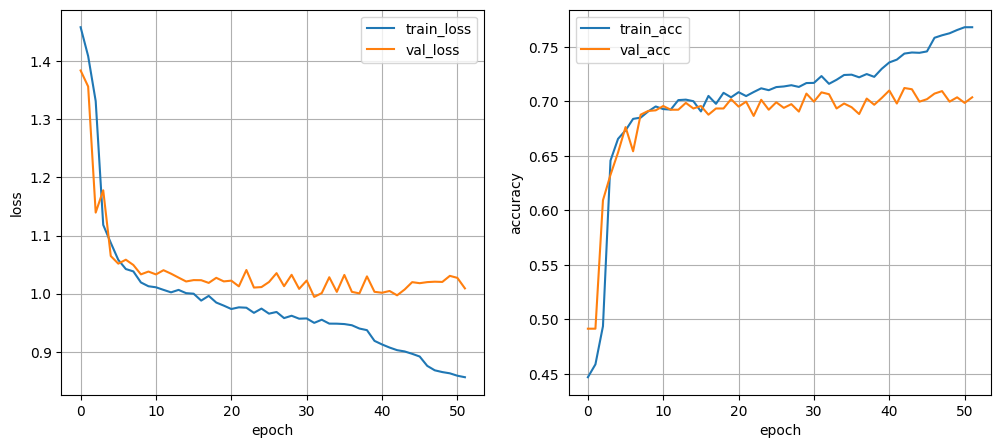


--- Evaluating Best Model on Validation Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embed_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'swin_block_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'swin_block_9', however the layer does 

Best model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━

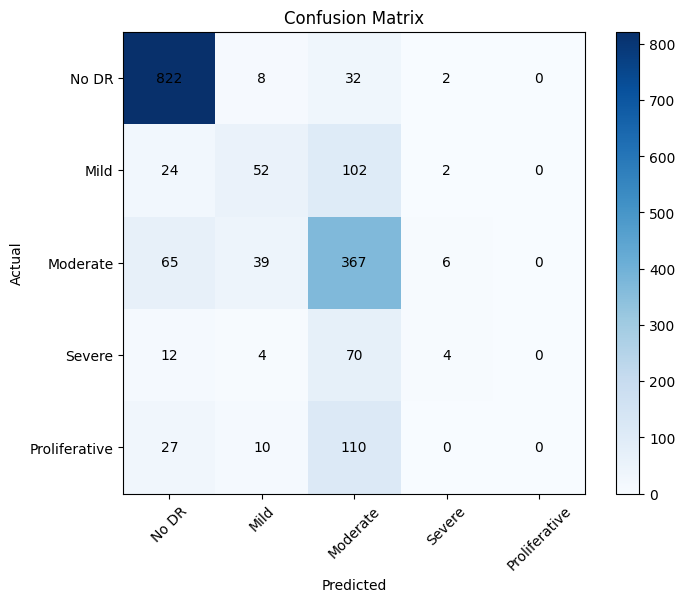

In [4]:
plot_history(history)
# To load a model with custom layers, we must provide a dictionary
# mapping the layer names to their class definitions.
custom_objects = {
    "DropPath": DropPath,
    "PatchEmbed": PatchEmbed,
    "WindowAttention": WindowAttention,
    "SwinBlock": SwinBlock,
    "PatchMerging": PatchMerging,
}

print("\n--- Evaluating Best Model on Validation Set ---")
best_model = keras.models.load_model('best_swin_model.keras', custom_objects=custom_objects)
print("Best model loaded successfully!")
evaluate_and_report(best_model, val_ds, class_names=['No DR','Mild','Moderate','Severe','Proliferative'])